In [1]:
import sys
import numpy as np
from scipy import constants,linalg
from numba import jit, njit, prange, set_num_threads
import time
from matplotlib import pyplot as plt

set_num_threads(8)
np.set_printoptions(threshold=sys.maxsize)

Construct the potential matrix with the state of h,k,l,
h = -H,-H+1,...,-1,0,1,...,H-1,H
k = -K,-K+1,...,-1,0,1,...,K-1,K
l = -L,-L+1,...,-1,0,1,...,L-1,L
First constuct a symmetry matrix by pseudmatrix()
pseudomatrix will generate a P matrix with size ((2H+1)*(2K+1)*(2L+1))*((2H+1)*(2K+1)*(2L+1)) in a folloing form
[[[-H,-K,-L],[-H,-K,-L],...,[-H,-K,-L]],
[[-H,-K,-L+1],[-H,-K,-L+1],...,[-H,-K,-L+1]],
...
[[H-1,K,L],[H-1,K,L],...,[H-1,K,L]],
[[H,K,L],[H,K,L],...,[H,K,L]]]
P = P.transpose()-P 
Which P become the states of h,k,l matrix
the potential is the form $\frac{Coeff}{|G_i-G_j|}$ wiich equal to $\frac{Coeff}{|h^2+k^2+l^2}{\frac{2\pi}{a}}^2$
then we can generate potential matrix from P by useing result_matrix()


In [2]:
def potential_matrix(H,K,L,coefficient,reciprocal_basis):
    n=(2*H+1)*(2*K+1)*(2*L+1)
    pseudomatrix=pseudomatrix_kernal(H,K,L,n)
    pseudomatrix=pseudomatrix.transpose((1,0,2))-pseudomatrix
    result_matrix = result_matrix_kernal(pseudomatrix,H,K,L,n,reciprocal_basis)
    return result_matrix*coefficient


def potential_coefficient(a,charges,parameter):
    return -parameter*charges*constants.elementary_charge**2/(a**2*constants.pi*constants.epsilon_0)

In [3]:
@njit(parallel=True)
def pseudomatrix_kernal(H,K,L,n):
    pseudomatrix = np.zeros((n,n,3))
    for h in prange(-H,H+1):
        for k in prange(-K,K+1):
            for l in prange(-L,L+1):
                for j in prange(n):
                    pseudomatrix[(h+H)*((2*K+1)*(2*L+1))+(k+K)*(2*L+1)+(l+L),j]=np.array([h,k,l])
    return pseudomatrix

In [4]:
test_size = 7
pseudomatrix_test = pseudomatrix_kernal(test_size,test_size,test_size,(2*test_size+1)**3)
print((pseudomatrix_test.transpose((1,0,2)))[:3,:3])
print((pseudomatrix_test)[:3,:3])
print((pseudomatrix_test.transpose((1,0,2))-pseudomatrix_test)[:6,:6]**2)

[[[ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0.  0.  4.]
  [ 0.  0.  9.]
  [ 0.  0. 16.]
  [ 0.  0. 25.]]

 [[ 0.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0.  0.  4.]
  [ 0.  0.  9.]
  [ 0.  0. 16.]]

 [[ 0.  0.  4.]
  [ 0.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0.  0.  4.]
  [ 0.  0.  9.]]

 [[ 0.  0.  9.]
  [ 0.  0.  4.]
  [ 0.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0.  0.  4.]]

 [[ 0.  0. 16.]
  [ 0.  0.  9.]
  [ 0.  0.  4.]
  [ 0.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  0.  1.]]

 [[ 0.  0. 25.]
  [ 0.  0. 16.]
  [ 0.  0.  9.]
  [ 0.  0.  4.]
  [ 0.  0.  1.]
  [ 0.  0.  0.]]]


In [5]:
a = potential_matrix(H,K,L,1,SIMPLE_CUBIC)
print(a)

NameError: name 'H' is not defined

In [6]:
@njit(parallel=True)
def result_matrix_kernal(pseudomatrix,H,K,L,n,reciprocal_basis):
    result_matrix = np.zeros((n,n))
    for h in prange(-H,H+1):
        for k in prange(-K,K+1):
            for l in prange(-L,L+1):
                index = (h+H)*((2*K+1)*(2*L+1))+(k+K)*(2*L+1)+(l+L)
                for j in prange(n):
                    if j!=index:
                        result_matrix[index,j]=1/np.sum((pseudomatrix[index][j]*reciprocal_basis)**2)
    return result_matrix

In [7]:
potential_matrix_test = result_matrix_kernal(pseudomatrix_test.transpose((1,0,2))-pseudomatrix_test,test_size,test_size,test_size,(2*test_size+1)**3,SIMPLE_CUBIC)
print(potential_matrix_test[:5,:5])

NameError: name 'SIMPLE_CUBIC' is not defined

In [8]:
#%timeit potential_matrix(1,1,1,1)


H = $E_k$ + U
here we need to construct $E_k$ = $\frac{\hbar^2}{2m}({|k-G|}^2-{|k|}^2)$

In [9]:
def halmitonian(potential_matrix,k_vertor,H,K,L,reciprocal_basis):
    n=(2*H+1)*(2*K+1)*(2*L+1)
    halmitonian_matrix = halmitonian_kernal(k_vertor,H,K,L,reciprocal_basis,n)
    return halmitonian_matrix+potential_matrix


In [10]:
@njit(parallel=True)
def halmitonian_kernal(k_vector,H,K,L,reciprocal_basis,n):
    halmitonian_matrix = np.zeros((n,n))
    for h in prange(-H,H+1):
        for k in prange(-K,K+1):
            for l in prange(-L,L+1):
                index = (h+H)*((2*K+1)*(2*L+1))+(k+K)*(2*L+1)+(l+L)
                halmitonian_matrix[index,index]=np.sum((k_vector-(h*reciprocal_basis[0]+k*reciprocal_basis[1]+l*reciprocal_basis[2]))**2)
                
    return halmitonian_matrix

In [11]:
def states(N):
    num = np.floor(np.power(N,1.0/3))
    H = num//2
    K = num//2
    L = np.floor(N/((2*H+1)*(2*K+1))//2)
    return int(H),int(K),int(L)


def path_initialize(k_start,k_end,N=50):
    N = int(N)
    k_1 = np.linspace(k_start[0],k_end[0],endpoint=True,num=N)
    k_2 = np.linspace(k_start[1],k_end[1],endpoint=True,num=N)
    k_3 = np.linspace(k_start[2],k_end[2],endpoint=True,num=N)
    return np.array([k_1,k_2,k_3])


In [12]:
def band_structure(H,K,L,radius,charges,parameter,reciprocal_basis,Path):
    start = time.time()
    potentialmatrix=potential_matrix(H,K,L,potential_coefficient(radius,charges,parameter),reciprocal_basis)
    end = time.time()
    E_0 = constants.hbar**2*(2*constants.pi)**2/(2*radius**2*constants.electron_mass)
    potentialmatrix/=E_0
    print(f"Potential matrix calculation done in {end-start:.2f} seconds")
    bands = []
    for path in Path:
        for i in np.arange(len(path[0])):
            start = time.time()
            Ham = halmitonian(potentialmatrix,np.array([path[0][i],path[1][i],path[2][i]]),H,K,L,reciprocal_basis)
            end = time.time()
            print(f"Hamiltonian calculation done in {end-start:.2f} seconds")
            start = time.time()
            eigen_value= linalg.eigvalsh(Ham)
            end = time.time()
            print(f"Eigenvalue calculation done in {end-start:.2f} seconds")
            bands.append(np.sort(eigen_value.real)*E_0)
            print(i)
            print(f"Processed k-point {i+1}/{len(path[0])}")
    return np.stack(bands, axis=-1)

In [13]:
RECIPROCAL_BASIS = np.array([
        [-1, 1, 1],
        [1, -1, 1],
        [1, 1, -1]
])

# sample points per k-path
n = 100

# symmetry points in the Brillouin zone
G = np.array([0, 0, 0])
L = np.array([1/2, 1/2, 1/2])
K = np.array([3/4, 3/4, 0])
X = np.array([0, 0, 1])
W = np.array([1, 1/2, 0])
U = np.array([1/4, 1/4, 1])

# k-paths
lambd = path_initialize(L, G, n)
delta = path_initialize(G, X, n)
x_uk = path_initialize(X, U, n / 4)
sigma = path_initialize(K, G, n)

H,K,L=7,7,7

In [14]:
SIMPLE_CUBIC = np.array([[1,0,0],[0,1,0],[0,0,1]])

GG = np.array([0,0,0])
XX = np.array([0,0.5,0])
MM = np.array([0.5,0.5,0])
RR = np.array([0.5,0.5,0.5])

GX = path_initialize(GG,XX,50)
XM = path_initialize(XX,MM,50)
MR = path_initialize(MM,RR,50)
RG = path_initialize(RR,GG,50)

In [15]:
bands_simple = band_structure(H,K,L,1e-10,1,0,SIMPLE_CUBIC,[GX,XM,MR,RG])


Potential matrix calculation done in 2.47 seconds
Hamiltonian calculation done in 1.27 seconds
Eigenvalue calculation done in 3.43 seconds
0
Processed k-point 1/50
Hamiltonian calculation done in 0.05 seconds
Eigenvalue calculation done in 3.38 seconds
1
Processed k-point 2/50
Hamiltonian calculation done in 0.06 seconds
Eigenvalue calculation done in 3.21 seconds
2
Processed k-point 3/50
Hamiltonian calculation done in 0.05 seconds
Eigenvalue calculation done in 4.11 seconds
3
Processed k-point 4/50
Hamiltonian calculation done in 0.08 seconds
Eigenvalue calculation done in 3.16 seconds
4
Processed k-point 5/50
Hamiltonian calculation done in 0.05 seconds
Eigenvalue calculation done in 3.02 seconds
5
Processed k-point 6/50
Hamiltonian calculation done in 0.05 seconds
Eigenvalue calculation done in 3.29 seconds
6
Processed k-point 7/50
Hamiltonian calculation done in 0.05 seconds
Eigenvalue calculation done in 3.34 seconds
7
Processed k-point 8/50
Hamiltonian calculation done in 0.06 s

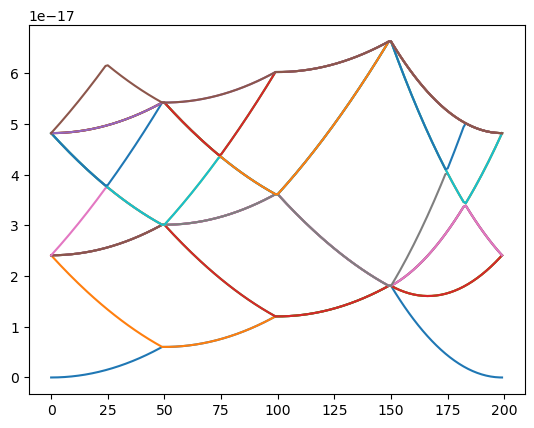

In [16]:
for i in bands_simple[:16]:
    plt.plot(i)

In [17]:


bands1 = band_structure(H,K,L,0.0365*1e-10,14,1,RECIPROCAL_BASIS,[lambd,delta,x_uk,sigma])


Potential matrix calculation done in 0.70 seconds
Hamiltonian calculation done in 0.08 seconds
Eigenvalue calculation done in 4.98 seconds
0
Processed k-point 1/100
Hamiltonian calculation done in 0.08 seconds
Eigenvalue calculation done in 5.10 seconds
1
Processed k-point 2/100
Hamiltonian calculation done in 0.08 seconds
Eigenvalue calculation done in 4.81 seconds
2
Processed k-point 3/100
Hamiltonian calculation done in 0.08 seconds
Eigenvalue calculation done in 3.60 seconds
3
Processed k-point 4/100
Hamiltonian calculation done in 0.07 seconds
Eigenvalue calculation done in 3.56 seconds
4
Processed k-point 5/100
Hamiltonian calculation done in 0.07 seconds
Eigenvalue calculation done in 4.58 seconds
5
Processed k-point 6/100
Hamiltonian calculation done in 0.08 seconds
Eigenvalue calculation done in 4.52 seconds
6
Processed k-point 7/100
Hamiltonian calculation done in 0.08 seconds
Eigenvalue calculation done in 4.53 seconds
7
Processed k-point 8/100
Hamiltonian calculation done i

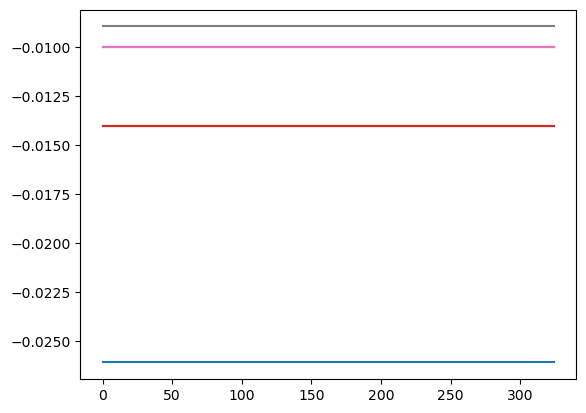

In [18]:
for i in bands1[:8]:
    plt.plot(i)


In [ ]:
bands_10_10 = band_structure(H,K,L,0.0365*1e-10,14,1e-10,RECIPROCAL_BASIS,[lambd,delta,x_uk,sigma])

In [ ]:
for i in bands_10_10[:8]:
    plt.plot(i)

In [ ]:
bands_10_15 = band_structure(H,K,L,0.0365*1e-10,14,1e-15,RECIPROCAL_BASIS,[lambd,delta,x_uk,sigma])

In [ ]:
for i in bands_10_15[:8]:
    plt.plot(i)

In [ ]:
bands_10_20 = band_structure(H,K,L,0.0365*1e-10,14,1e-20,RECIPROCAL_BASIS,[lambd,delta,x_uk,sigma])

In [ ]:
for i in bands_10_20[:8]:
    plt.plot(i)

In [ ]:
bands_10_11 = band_structure(H,K,L,0.0365*1e-10,14,1e-11,RECIPROCAL_BASIS,[lambd,delta,x_uk,sigma])

In [ ]:
for i in bands_10_11[:8]:
    plt.plot(i)

In [ ]:
bands_0 = band_structure(H,K,L,1e-10,1,0,RECIPROCAL_BASIS,[lambd,delta,x_uk,sigma])

In [ ]:
for i in bands_0[:8]:
    plt.plot(i)

In [ ]:
from matplotlib import pyplot as plt

%matplotlib inline
bands = bands1[:8]
# offset the bands so that the top of the valence bands is at zero
bands -= max(bands[3])

plt.figure(figsize=(15, 9))

ax = plt.subplot(111)

# remove plot borders
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# limit plot area to data
plt.xlim(0, len(bands))
plt.ylim(min(bands[0]) - 1, max(bands[7]) + 1)

# custom tick names for k-points
xticks = n * np.array([0, 0.5, 1, 1.5, 2, 2.25, 2.75, 3.25])
plt.xticks(xticks, ('$L$', '$\Lambda$', '$\Gamma$', '$\Delta$', '$X$', '$U,K$', '$\Sigma$', '$\Gamma$'), fontsize=18)
plt.yticks(fontsize=18)

# horizontal guide lines every 2.5 eV
for y in np.arange(-25, 25, 2.5):
    plt.axhline(y, ls='--', lw=0.3, color='black', alpha=0.3)

# hide ticks, unnecessary with gridlines
plt.tick_params(axis='both', which='both',
                top='off', bottom='off', left='off', right='off',
                labelbottom='on', labelleft='on', pad=5)

plt.xlabel('k-Path', fontsize=20)
plt.ylabel('E(k) (eV)', fontsize=20)

plt.text(135, -18, 'Fig. 1. Band structure of Si.', fontsize=12)

# tableau 10 in fractional (r, g, b)
colors = 1 / 255 * np.array([
    [31, 119, 180],
    [255, 127, 14],
    [44, 160, 44],
    [214, 39, 40],
    [148, 103, 189],
    [140, 86, 75],
    [227, 119, 194],
    [127, 127, 127],
    [188, 189, 34],
    [23, 190, 207]
])

for band, color in zip(bands, colors):
    plt.plot(band, lw=2.0, color=color)

plt.show()

In [ ]:

M = potential_matrix(H,K,L,potential_coefficient(5.43,144,1))

Haml,factor = halmitonian(M,np.array([lambd[0][0],lambd[1][0],lambd[2][0]]),H,K,L,reciprocal_basis=RECIPROCAL_BASIS,a=5.43)
print(Haml)
eigen_value,eigen_vector = linalg.eig(Haml)
print(np.sort(eigen_value))

In [ ]:
constants.electron_mass*constants.elementary_charge**2/(2*constants.pi**3*constants.epsilon_0*constants.hbar**2)


In [ ]:
potential_coefficient(5.43,144,1)

In [ ]:
for i in sigma:
    print(sigma)

In [ ]:
14*constants.elementary_charge**2/(1e-10**2*constants.pi*constants.epsilon_0)/constants.electron_volt

In [ ]:
constants.hbar**2*(2*constants.pi)**2/(2*1e-10**2*constants.electron_mass)

In [43]:
BCC = np.array([[0,1,1],[1,0,1],[1,1,0]])
G = np.array([0,0,0])
H = np.array([0,0,1])
P = np.array([0.5,0.5,0.5])
N = np.array([0.5,0.5,0])

GH = path_initialize(G,H,50)
HP = path_initialize(H,P,50)
PG = path_initialize(P,G,50)
GN = path_initialize(G,N,50)
NH = path_initialize(N,H,50)
sodium_band = band_structure(3,3,3,4.29*1e-10,11,0.0109*1e-10,BCC,[GH,HP,PG,GN,NH])

Potential matrix calculation done in 0.01 seconds
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.02 seconds
0
Processed k-point 1/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.01 seconds
1
Processed k-point 2/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.02 seconds
2
Processed k-point 3/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.01 seconds
3
Processed k-point 4/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.01 seconds
4
Processed k-point 5/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.01 seconds
5
Processed k-point 6/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.01 seconds
6
Processed k-point 7/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.01 seconds
7
Processed k-point 8/50
Hamiltonian calculation done in 0.00 s

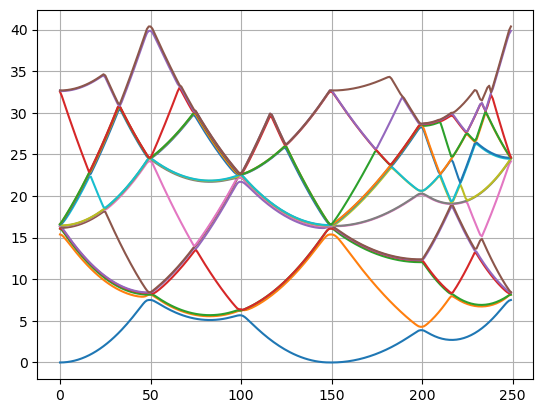

In [72]:
for i in sodium_band[:16]:
    plt.plot(i/constants.electron_volt)
plt.grid(which='both')

In [36]:
sodium_band.size/250

27.0

1.4142135623730951

In [59]:
H=7
K=7
L=7
N=H*K*L
d=11
a=4.29*1e-10
V = np.sqrt(np.sum(H*BCC[0]*np.cross(K*BCC[1],L*BCC[2])**2))
(3*np.pi**2*N*d/V)**(2/3)

71.87289499112522

In [67]:
(3.23*constants.elementary_charge*2*constants.electron_mass/(constants.hbar**2))**(0.5)/(2*np.pi)*4.29e-10

0.6286620095226423